In [19]:
from dotenv import load_dotenv
from typing import Dict, Any, List
import yfinance as yf
load_dotenv() 

True

### Tools to fetch using NewsAPI and yfinance

In [20]:
def get_stock_data(ticker: str) -> Dict[str, Any]:
    """Fetches key financial data for a
      given stock ticker using yfinance.
    
    Args:
        ticker (str): The stock ticker
      symbol (e.g., "AAPL", "MSFT").
    
    Returns:
        Dict[str, Any]: A dictionary
      containing selected stock information,
      or an error message if the ticker is invalid.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info

        if not info:
            return {"error": f"Could not retrieve data for ticker: {ticker}. It might be invalid."}

        # Extract relevant information
        data = {
            "ticker": ticker,
            "shortName": info.get("shortName", "N/A"),
            "currentPrice": info.get("currentPrice", "N/A"),
            "previousClose": info.get("previousClose", "N/A"),
            "open": info.get("open", "N/A"),
            "dayHigh": info.get("dayHigh", "N/A"),
            "dayLow": info.get("dayLow", "N/A"),
            "volume": info.get("volume", "N/A"),
            "marketCap": info.get("marketCap", "N/A"),
            "currency": info.get("currency", "N/A"),
            "exchange": info.get("exchange", "N/A"),
            "sector": info.get("sector", "N/A"),
            "industry": info.get("industry", "N/A"),
            "longBusinessSummary": info.get("longBusinessSummary", "N/A")
        }
        return data
    except Exception as e:
        return {"error": f"An unexpected error occurred while fetching data for {ticker}: {e}"}


def get_news_articles(query: str) -> List[Dict]:
    """Fetch news articles based on query or ticker symbol.
    
    Args:
        query: Search keywords or phrases (str)
            
    Returns:
        List of news articles with title, description, url, etc.
    """
    try:
        from newsapi import NewsApiClient
        import os
        
        newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))
        response = newsapi.get_everything(
            q=query,
            language="en",
            sort_by="publishedAt",
            page_size=10
        )
        return response.get("articles", [])
    except Exception as e:
        return {"error": f"Failed to fetch news: {str(e)}"}

### Creating tool

In [8]:
from langchain_openai import ChatOpenAI

tools = [
    get_stock_data,
    get_news_articles
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

System message and initial Node

In [22]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

class NewsSentiment(BaseModel):
    news_headline: str = Field(..., description="News Headline")
    sentiment: float = Field(..., description="News rating between -1 and +1")

class StockAnalysis(BaseModel):
    key_words: List[str] = Field(..., description="Key words related to finance from recent news")
    news_sentiment: List[NewsSentiment] = Field(..., description="A list of news headlines and its sentiment")
    overall_sentiment_rating: float = Field(..., description="Overall sentiment of the company in the news, rated between -10 and +10")
    reasoning: str = Field(..., description="A one line reason for assigning the overall sentiment rating")

parser = JsonOutputParser(pydantic_object=StockAnalysis)

# System message
sys_msg = SystemMessage(content=f"""
You are an expert financial analyst. Analyze the stock data and news, 
then respond with a comprehensive analysis in JSON format.

Response must be a valid JSON object matching this schema:
{parser.get_format_instructions()}

Guidelines:
- Be objective and data-driven
- Include both technical and fundamental analysis
- Consider recent news impact
- Provide clear, actionable recommendations
- overall sentiment rating score should reflect certainty (-10 to +10)
""")


def prepare_human_message(ticker: str) -> HumanMessage:
    return HumanMessage(content=f"""
Analyze this stock data and provide your analysis in the requested JSON format.

STOCK DATA for {ticker.upper()}:

Provide your analysis in the exact JSON format specified, with no additional text.
""")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


Creating a ReAct Graph 

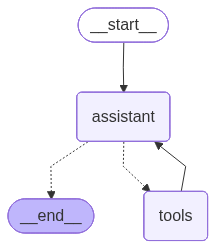

In [16]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Create a parser prompt for prompting LLM to give response as expected

Initialise Memory configuration and Agent call

In [27]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [prepare_human_message("AAPL")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)

for m in messages['messages']:
    m.pretty_print()

# final_message = messages["messages"][-1]

# # If you want to extract just the content
# final_output = final_message.content

# # Print or use the final output
# print("Final Output:", final_output)


================================ Human Message =================================


Analyze this stock data and provide your analysis in the requested JSON format.

STOCK DATA for AAPL:

Provide your analysis in the exact JSON format specified, with no additional text.

================================== Ai Message ==================================
Tool Calls:
  get_stock_data (call_LACJqJTpgYxwSCaCIDLhNohG)
 Call ID: call_LACJqJTpgYxwSCaCIDLhNohG
  Args:
    ticker: AAPL
  get_news_articles (call_tELOiCyj4T83Dr7O0kNGsvDP)
 Call ID: call_tELOiCyj4T83Dr7O0kNGsvDP
  Args:
    query: AAPL
================================= Tool Message =================================
Name: get_stock_data

{"ticker": "AAPL", "shortName": "Apple Inc.", "currentPrice": 258.06, "previousClose": 256.48, "open": 256.53, "dayHigh": 258.52, "dayLow": 256.11, "volume": 32126418, "marketCap": 3829710979072, "currency": "USD", "exchange": "NMS", "sector": "Technology", "industry": "Consumer Electronics", "longBusin